In [1]:
# Run this cell
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from time import time
import pandas as pd
import numpy as np

import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, Lambda

# import by me
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, LSTM #, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from gensim import models

from matplotlib import pyplot as plt

from torchvision import transforms

from sklearn.metrics import precision_recall_fscore_support as score

from datetime import datetime

from scipy import spatial

from keras.layers import merge

from scipy.spatial.distance import cityblock

In [2]:
# Run this cell
class ModelParam(object):
    """
    define the parameters of the model
    """
    def __init__(
        self, 
        input_size1, # sentence length of language1
        input_size2, # sentence length of language2
        vocab_size, 
        sent_size, 
        embedding_dim,
        embedding_weights,
        #sent_vector,
    ):
        self.input_size1 = input_size1
        self.input_size2 = input_size2
        self.vocab_size = vocab_size
        self.sent_size = sent_size
        self.embedding_dim = embedding_dim
        self.embedding_weights = embedding_weights
        #self.sent_vector = sent_vector

In [3]:
# Run this cell
# initialize some variables
w2v_model = KeyedVectors.load_word2vec_format('vectors_embeddings.bin', binary=True)

# Inpute size
w2v_dim = 200

n_units_1st_layer = 64

# Training epoch number
n_epoch = 100

# Model Optimization parameters
batch_size = 64
gradient_clipping_norm = 1.25

# File name (or the intact file path) which indicates the model you want to save.
saved_model = "embeddings_saved_model.hdf5"

# Whether use early stopping
# If you turn off early stopping the auc values after each epoch will not be computed.
early_stopping_or_not = True

# Control parameters of early stopping
min_delta_value = 1e-3
patience_steps_num =50

In [4]:
# Run this cell

# TRAIN_CSV = 'train1.csv'
TRAIN_CSV = 'train_original.csv'
TEST_CSV = 'test.csv'

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

def text_to_word_list(text):
    
    text = str(text)
    text = text.upper()
    text = text.split()

    return text

In [5]:
# Run this cell

#test counters
wordFound = 0
wordNotFound = 0
# Prepare embedding
vocabulary = dict()
 # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
inverse_vocabulary = ['<unk>'] 

questions_cols = ['lang1', 'lang2']

# Iterate over the questions only of both training and test datasets
#For now Test dataset is a dummy small dataset with some instructions from training dataset
dataset = train_df
for index, row in dataset.iterrows():

    # Iterate through the text of both questions of the row
    for question in questions_cols:

        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):
            #print(word)
            # Check for unwanted words
            if word not in w2v_model.wv:
                print("Unknown word is found!!!")
                wordNotFound += 1
                continue


            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

            wordFound += 1
        # Replace questions as word to question as number representation
        dataset.at[index, question] = q2n
            
embedding_dim = w2v_dim
# This will be the embedding matrix
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embeddings[0] = 0  # So that the padding will be ignored

#print test counters
print("words found in model = ")
print(wordFound)
print("words NOT found in model")
print(wordNotFound)

VOCAB_SIZE = len(vocabulary)
print('vocab size ',VOCAB_SIZE)
# Building the embedding matrix
for word, index in vocabulary.items():
    #print('index ', index)
    if word in w2v_model.wv:
        #print(word)
        #print("above word found")
        embeddings[index] = w2v_model.wv[word]
        
print("This is the loaded embeddings")

print(embeddings)

# MOVQ~RBX,[RSP+0] LDR~R0,[R10+0]
# values = vocabulary.values()
# idx = values.index("MOVQ~RBX,[RSP+0]")
# print('idx = ',idx)
# vocabulary.get('LDR~R0,[R10+0]')

/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


words found in model = 
1745024
words NOT found in model
0
vocab size  43254


/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


This is the loaded embeddings
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.02004805e-02 -9.54385817e-01  4.67588007e-01 ...  2.22066343e-01
   6.05751812e-01 -8.38298917e-01]
 [-6.98797181e-02 -1.16516185e+00  2.76971191e-01 ...  6.78086698e-01
   4.69638079e-01 -5.87370574e-01]
 ...
 [-2.02880870e-03 -2.38929759e-03 -2.26852414e-03 ... -1.52107235e-03
  -1.53823849e-03  8.48464959e-04]
 [ 3.94527204e-02 -5.25413267e-02  2.50864401e-02 ... -1.61156747e-02
   1.87546294e-02 -1.14719808e-01]
 [ 1.00708006e-04  6.65512111e-04 -2.10678112e-03 ...  7.23190315e-04
   2.73895275e-04  1.80854800e-03]]


In [52]:
# Run this cell
# This is the model for generating predictions
# Takes parameters from ModelParam class

class crossLingualModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        #Ifty
#         self.embedding = nn.Embedding(
#             model_param.vocab_size,
#             model_param.embedding_dim
#         )
        #self.embedding = embeddings
        #self.sent_vector = model_param.sent_vector
        
        # NEED TO CHECK PARAMETERS
        # Keras embedding
#         self.embedding = Embedding(model_param.vocab_size,
#                             model_param.embedding_dim,
#                             weights=[embeddings],
#                             #input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)
        # torch embedding
        ## No CHANGE in embedding for both random and pre trained vectors
        self.embedding = nn.Embedding(model_param.vocab_size,
                            model_param.embedding_dim)
#         weight = torch.FloatTensor(model_param.embedding_weights)
#         self.embedding = nn.Embedding.from_pretrained(weight, freeze=False)

#         self.embedding.weight.data.copy_(torch.from_numpy(model_param.embedding_weights))
        self.embedding.weight.data.copy_(model_param.embedding_weights)
    
        self.embedding.weight.requires_grad = True # for updating weights
        
        self.sent = torch.randn(
            model_param.sent_size, 
            requires_grad=True, 
            dtype=torch.float
        )
        
        self.linear = nn.Linear(
            model_param.embedding_dim + model_param.sent_size,
            model_param.vocab_size
        )
        
        self.softmax = nn.LogSoftmax(dim=1)
        
#         self.sigmoid = nn.Sigmoid()
        
        
        
    # x1: embeddings of context words in lang1
    # x2: embeddings of context words in lang2
    def forward(self, x1, x2, sent_vector):
        if(len(sent_vector) == 0 ):
            #Do Testing part
            #Now x1 and x2 are instructions in lang1 and lang2
            
            sent_vector_lang1 = text_to_word_list(x1)
            sent_vector_lang1 = [word for word in sent_vector_lang1 if word in w2v_model.wv]
            sent_vector_lang1_index_array = []
            for word in sent_vector_lang1:
                sent_vector_lang1_index_array.append(vocabulary.get(word))
            sent_vector_lang1 = np.array(sent_vector_lang1_index_array)
            
            sent_vector_lang1 = torch.Tensor(sent_vector_lang1)
#             print('sent_vector_lang1 5', sent_vector_lang1)
            sent_vector_lang1 = sent_vector_lang1.to(torch.int)
#             print('sent_vector_lang1 6', sent_vector_lang1)
            
            sent_vector_lang1 = self.embedding(sent_vector_lang1)
            #print('embedding_output1 ',embedding_output1)
#             sent_vector_lang1 = sent_vector_lang1.numpy()
            if len(sent_vector_lang1) >= 1:
                sent_vector_lang1 = torch.Tensor([x.sum()/len(x) for x in sent_vector_lang1.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang1 = np.mean(sent_vector_lang1, axis=0)
            else:
                sent_vector_lang1 = torch.zeros(w2v_dim)
                
            sent_vector_lang2 = text_to_word_list(x2)
            sent_vector_lang2 = [word for word in sent_vector_lang2 if word in w2v_model.wv]
            sent_vector_lang2_index_array = []
            for word in sent_vector_lang2:
                sent_vector_lang2_index_array.append(vocabulary.get(word))
            sent_vector_lang2 = np.array(sent_vector_lang2_index_array)
            
            sent_vector_lang2 = torch.Tensor(sent_vector_lang2)
#             print('sent_vector_lang2 5', sent_vector_lang2)
            sent_vector_lang2 = sent_vector_lang2.to(torch.int)
#             print('sent_vector_lang2 6', sent_vector_lang2)
            
            sent_vector_lang2 = self.embedding(sent_vector_lang2)
#             print('embedding_output sent_vector_lang2 ',sent_vector_lang2)
#             sent_vector_lang2 = sent_vector_lang2.numpy()
            if len(sent_vector_lang2) >= 1:
                sent_vector_lang2 = torch.Tensor([x.sum()/len(x) for x in sent_vector_lang2.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang2 = np.mean(sent_vector_lang2, axis=0)
            else:
                sent_vector_lang2 = torch.zeros(w2v_dim)
            
            #Not sure if these two lines should be added
#             print('sent_vector_lang1 size ', sent_vector_lang1.size())
#             sent_vector_lang1 = self.linear(sent_vector_lang1)
#             sent_vector_lang2 = self.linear(sent_vector_lang2)
            
            return [sent_vector_lang1, sent_vector_lang2]
        else:
            #Do prediction part
            #x1 = torch.FloatTensor(x1)
            #x2= torch.FloatTensor(x2)

            #modify part
            #NEED to get indices from words list in x1 and x2
            x1_index_array = []
            for word in x1:
                x1_index_array.append(vocabulary.get(word))

            x2_index_array = []
            for word in x2:
                x2_index_array.append(vocabulary.get(word))


#             x1 = np.array(x1_index_array) #, dtype=np.int32)
#             x2 = np.array(x2_index_array) #, dtype=np.int32)

            x1 = x1_index_array #, dtype=np.int32)
            x2 = x2_index_array #, dtype=np.int32)
            
            x1 = torch.Tensor(x1)
            x2 = torch.Tensor(x2)
            x1 = x1.to(torch.int)
            x2 = x2.to(torch.int)
            
            
    #         x1 = np.array((x1))
    #         x2 = np.array((x2))
            embedding_output1 = self.embedding(x1)
#             tmp = 3
#             if tmp in x1:
#             embeddings_layer_weights = self.embedding.get_weights()[0]
#             print('embeddings_layer_weights ',embeddings_layer_weights)

#             print('for x1 = ', x1)
#             print('embedding_output1',embedding_output1)
                
            # Write embedding o/p to file
            f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
            f.write(str(x1))
            f.write(str(embedding_output1))
            f.close()
        
#             current_vec = self.embedding.weight
#             if prev_vec != current_vec:
#                 print('!=')
#             else:
#                 print('==')
#             prev_vec = current_vec
            
#             print("embedding weight ",self.embedding.weight)

#             embedding_output1 = torch.Tensor(embedding_output1.numpy())

    #         embedding_output1 = torch.FloatTensor(embedding_output1) #torch.Tensor(embedding_output1)
            embedding_output1 = F.relu(embedding_output1)
        
#             f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
#             f.write(str(x1))
#             f.write(str(embedding_output1))
#             f.close()
#             print('embedding_output1 relu size = ',embedding_output1.size())
#             print('embedding_output1 relu = ',embedding_output1)
            
            
            
            embedding_output2 = self.embedding(x2)
#             embedding_output2 = torch.Tensor(embedding_output2.numpy())
            embedding_output2 = F.relu(embedding_output2)

            #working part
    #         embedding_output1 = x1 
    #         embedding_output1 = F.relu(embedding_output1)
    #         embedding_output2 = x2 
    #         embedding_output2 = F.relu(embedding_output2)



            sum_embedding1 = torch.Tensor([x.sum() for x in embedding_output1.transpose(0, -1)])
            sum_embedding2 = torch.Tensor([x.sum() for x in embedding_output2.transpose(0, -1)])
            sent = self.sent

            # For modifying sent vector using embedding layer
#             print('sent_vector 1', sent_vector)
            sent_vector = text_to_word_list(sent_vector)
#             print('sent_vector 2', sent_vector)
            sent_vector = [word for word in sent_vector if word in w2v_model.wv]
#             print('sent_vector 3', sent_vector)
        
            sent_vector_index_array = []
            for word in sent_vector:
                sent_vector_index_array.append(vocabulary.get(word))
#             sent_vector = np.array(sent_vector_index_array)
            sent_vector = sent_vector_index_array
#             print('sent_vector 4', sent_vector)
            
            
            sent_vector = torch.Tensor(sent_vector)
#             print('sent_vector 5', sent_vector)
            
            sent_vector = sent_vector.to(torch.int)
#             print('sent_vector 6', sent_vector)
            
            
            sent_vector = self.embedding(sent_vector)
#             print('sent_vector 7', sent_vector)
            
            #print('embedding_output1 ',embedding_output1)
#             sent_vector = sent_vector.numpy()
#             if len(sent_vector) >= 1:
#             if tf.equal(tf.size(sent_vector), 0):
#                  sent_vector = torch.mean(sent_vector)
#             else:
#                 sent_vector = torch.zeros(w2v_dim)

#             sent_vector = torch.split(sent_vector, 1)
#             sent_vector = torch.mean(torch.stack(sent_vector))

#             mean = torch.mean(torch.stack(my_list))
#             sent_vector = torch.mean(sent_vector)

            # may need to change later
#             sent_vector = sent_vector.detach().numpy()
#             sent_vector = np.mean(sent_vector)
        
            # NEED TO FIND A WAY TO GET ELEMENT WISE AVERAGE OF TENSORS
            sent_vector = torch.Tensor([x.sum()/len(x) for x in sent_vector.transpose(0, -1)]) # .transpose(0, -1)
        
#             print('sent_vector 8', sent_vector)
    
#             print('sent_vector.size ',sent_vector.size())
#             print('sum_embedding1.size ',sum_embedding1.size())
            

            concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
            concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)


    #         concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
    #         concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)
    
#             print('concat1 size ', concat1.size())

            linear_output1 = self.linear(concat1)
            linear_output2 = self.linear(concat2)
            
            print(self.linear.weight)



#             pred1 = self.softmax(linear_output1.reshape(1,-1))
#             pred2 = self.softmax(linear_output2.reshape(1,-1))
            
            
#             pred1 = self.sigmoid(linear_output1.reshape(1,-1))
#             pred2 = self.sigmoid(linear_output2.reshape(1,-1))
            
#             pred1 = pred1.narrow(1,0,200)
#             pred2 = pred2.narrow(1,0,200)
            

            # May need to sort
    #         print('pred1 size ', pred1.size())
    #         pred1 = torch.cat([pred1[0:200]]) #pred1[:200] #torch.reshape(pred1, (200, -1))
    #         pred2 = torch.cat([pred2[0:200]]) #pred2[:200] #torch.reshape(pred2, (200, -1))
#             print('after narrow pred1 size ', pred1.size())

            return [self.softmax(linear_output1.reshape(1,-1)).narrow(1,0,200), self.softmax(linear_output2.reshape(1,-1)).narrow(1,0,200)]
#             return [self.softmax(linear_output1.reshape(1,-1)), self.softmax(linear_output2.reshape(1,-1))]

In [6]:
# Run this cell
# TRY WITH OUT REWRAPPING
# This is the model for generating predictions
# Takes parameters from ModelParam class

class crossLingualModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        #Ifty
#         self.embedding = nn.Embedding(
#             model_param.vocab_size,
#             model_param.embedding_dim
#         )
        #self.embedding = embeddings
        #self.sent_vector = model_param.sent_vector
        
        # NEED TO CHECK PARAMETERS
        # Keras embedding
#         self.embedding = Embedding(model_param.vocab_size,
#                             model_param.embedding_dim,
#                             weights=[embeddings],
#                             #input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)
        # torch embedding
        ## No CHANGE in embedding for both random and pre trained vectors
        self.embedding = nn.Embedding(model_param.vocab_size,
                            model_param.embedding_dim)
#         weight = torch.FloatTensor(model_param.embedding_weights)
#         self.embedding = nn.Embedding.from_pretrained(weight, freeze=False)

#         self.embedding.weight.data.copy_(torch.from_numpy(model_param.embedding_weights))
        self.embedding.weight.data.copy_(model_param.embedding_weights)
    
        self.embedding.weight.requires_grad = True # for updating weights
        
        self.sent = torch.randn(
            model_param.sent_size, 
            requires_grad=True, 
            dtype=torch.float
        )
        
        self.linear = nn.Linear(
            model_param.embedding_dim + model_param.sent_size,
            model_param.vocab_size
        )
        
        self.softmax = nn.LogSoftmax(dim=1)
        
#         self.sigmoid = nn.Sigmoid()
        
        
        
    # x1: embeddings of context words in lang1
    # x2: embeddings of context words in lang2
    def forward(self, x1, x2, sent_vector):
        if(len(sent_vector) == 0 ):
            #Do Testing part
            #Now x1 and x2 are instructions in lang1 and lang2
            
            sent_vector_lang1 = text_to_word_list(x1)
            sent_vector_lang1 = [word for word in sent_vector_lang1 if word in w2v_model.wv]
            sent_vector_lang1_index_array = []
            for word in sent_vector_lang1:
                sent_vector_lang1_index_array.append(vocabulary.get(word))
#             sent_vector_lang1 = np.array(sent_vector_lang1_index_array)
            sent_vector_lang1 = sent_vector_lang1_index_array
            
            
            sent_vector_lang1 = torch.Tensor(sent_vector_lang1)
#             print('sent_vector_lang1 5', sent_vector_lang1)
            sent_vector_lang1 = sent_vector_lang1.to(torch.int)
#             print('sent_vector_lang1 6', sent_vector_lang1)
            
            sent_vector_lang1 = self.embedding(sent_vector_lang1)
            #print('embedding_output1 ',embedding_output1)
#             sent_vector_lang1 = sent_vector_lang1.numpy()
            if len(sent_vector_lang1) >= 1:
                sent_vector_lang1 = torch.stack([x.sum()/len(x) for x in sent_vector_lang1.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang1 = np.mean(sent_vector_lang1, axis=0)
            else:
                sent_vector_lang1 = torch.zeros(w2v_dim)
                
            sent_vector_lang2 = text_to_word_list(x2)
            sent_vector_lang2 = [word for word in sent_vector_lang2 if word in w2v_model.wv]
            sent_vector_lang2_index_array = []
            for word in sent_vector_lang2:
                sent_vector_lang2_index_array.append(vocabulary.get(word))
#             sent_vector_lang2 = np.array(sent_vector_lang2_index_array)
            sent_vector_lang2 = sent_vector_lang2_index_array
            
            
            sent_vector_lang2 = torch.Tensor(sent_vector_lang2)
#             print('sent_vector_lang2 5', sent_vector_lang2)
            sent_vector_lang2 = sent_vector_lang2.to(torch.int)
#             print('sent_vector_lang2 6', sent_vector_lang2)
            
            sent_vector_lang2 = self.embedding(sent_vector_lang2)
#             print('embedding_output sent_vector_lang2 ',sent_vector_lang2)
#             sent_vector_lang2 = sent_vector_lang2.numpy()
            if len(sent_vector_lang2) >= 1:
                sent_vector_lang2 = torch.stack([x.sum()/len(x) for x in sent_vector_lang2.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang2 = np.mean(sent_vector_lang2, axis=0)
            else:
                sent_vector_lang2 = torch.zeros(w2v_dim)
            
            #Not sure if these two lines should be added
#             print('sent_vector_lang1 size ', sent_vector_lang1.size())
#             sent_vector_lang1 = self.linear(sent_vector_lang1)
#             sent_vector_lang2 = self.linear(sent_vector_lang2)
            
            return [sent_vector_lang1, sent_vector_lang2]
        else:
            #Do prediction part
            #x1 = torch.FloatTensor(x1)
            #x2= torch.FloatTensor(x2)

            #modify part
            #NEED to get indices from words list in x1 and x2
            x1_index_array = []
            for word in x1:
                x1_index_array.append(vocabulary.get(word))

            x2_index_array = []
            for word in x2:
                x2_index_array.append(vocabulary.get(word))


#             x1 = np.array(x1_index_array) #, dtype=np.int32)
#             x2 = np.array(x2_index_array) #, dtype=np.int32)

            x1 = x1_index_array #, dtype=np.int32)
            x2 = x2_index_array #, dtype=np.int32)
            
            x1 = torch.Tensor(x1)
            x2 = torch.Tensor(x2)
            x1 = x1.to(torch.int)
            x2 = x2.to(torch.int)
            
            
    #         x1 = np.array((x1))
    #         x2 = np.array((x2))
            embedding_output1 = self.embedding(x1)
#             tmp = 3
#             if tmp in x1:
#             embeddings_layer_weights = self.embedding.get_weights()[0]
#             print('embeddings_layer_weights ',embeddings_layer_weights)

#             print('for x1 = ', x1)
#             print('embedding_output1',embedding_output1)
                
            # Write embedding o/p to file
            f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
            f.write(str(x1))
            f.write(str(embedding_output1))
            f.close()
        
#             current_vec = self.embedding.weight
#             if prev_vec != current_vec:
#                 print('!=')
#             else:
#                 print('==')
#             prev_vec = current_vec
            
#             print("embedding weight ",self.embedding.weight)

#             embedding_output1 = torch.Tensor(embedding_output1.numpy())

    #         embedding_output1 = torch.FloatTensor(embedding_output1) #torch.Tensor(embedding_output1)
            embedding_output1 = F.relu(embedding_output1)
        
#             f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
#             f.write(str(x1))
#             f.write(str(embedding_output1))
#             f.close()
#             print('embedding_output1 relu size = ',embedding_output1.size())
#             print('embedding_output1 relu = ',embedding_output1)
            
            
            
            embedding_output2 = self.embedding(x2)
#             embedding_output2 = torch.Tensor(embedding_output2.numpy())
            embedding_output2 = F.relu(embedding_output2)

            #working part
    #         embedding_output1 = x1 
    #         embedding_output1 = F.relu(embedding_output1)
    #         embedding_output2 = x2 
    #         embedding_output2 = F.relu(embedding_output2)



#             sum_embedding1 = torch.Tensor([x.sum() for x in embedding_output1.transpose(0, -1)])
#             sum_embedding2 = torch.Tensor([x.sum() for x in embedding_output2.transpose(0, -1)])
            
            sum_embedding1 = torch.stack([x.sum() for x in embedding_output1.transpose(0, -1)])
            sum_embedding2 = torch.stack([x.sum() for x in embedding_output2.transpose(0, -1)])
#             print('sum_embedding1 ',sum_embedding1)
            sent = self.sent

            # For modifying sent vector using embedding layer
#             print('sent_vector 1', sent_vector)
            sent_vector = text_to_word_list(sent_vector)
#             print('sent_vector 2', sent_vector)
            sent_vector = [word for word in sent_vector if word in w2v_model.wv]
#             print('sent_vector 3', sent_vector)
        
            sent_vector_index_array = []
            for word in sent_vector:
                sent_vector_index_array.append(vocabulary.get(word))
#             sent_vector = np.array(sent_vector_index_array)
            sent_vector = sent_vector_index_array
#             print('sent_vector 4', sent_vector)
            
            
            sent_vector = torch.Tensor(sent_vector)
#             print('sent_vector 5', sent_vector)
            
            sent_vector = sent_vector.to(torch.int)
#             print('sent_vector 6', sent_vector)
            
            
            sent_vector = self.embedding(sent_vector)
#             print('sent_vector 7', sent_vector)
            
            #print('embedding_output1 ',embedding_output1)
#             sent_vector = sent_vector.numpy()
#             if len(sent_vector) >= 1:
#             if tf.equal(tf.size(sent_vector), 0):
#                  sent_vector = torch.mean(sent_vector)
#             else:
#                 sent_vector = torch.zeros(w2v_dim)

#             sent_vector = torch.split(sent_vector, 1)
#             sent_vector = torch.mean(torch.stack(sent_vector))

#             mean = torch.mean(torch.stack(my_list))
#             sent_vector = torch.mean(sent_vector)

            # may need to change later
#             sent_vector = sent_vector.detach().numpy()
#             sent_vector = np.mean(sent_vector)
        
            # NEED TO FIND A WAY TO GET ELEMENT WISE AVERAGE OF TENSORS
#             sent_vector = torch.Tensor([x.sum()/len(x) for x in sent_vector.transpose(0, -1)]) # .transpose(0, -1)
            sent_vector = torch.stack([x.sum()/len(x) for x in sent_vector.transpose(0, -1)]) # .transpose(0, -1)
#             print('sent_vector ', sent_vector)
#             print('sent_vector 8', sent_vector)
    
#             print('sent_vector.size ',sent_vector.size())
#             print('sum_embedding1.size ',sum_embedding1.size())
            

#             concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
#             concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)
            
            concat1 = torch.cat((sum_embedding1, sent_vector), 0)
            concat2 = torch.cat((sum_embedding2, sent_vector), 0)


    #         concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
    #         concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)
    
#             print('concat1 size ', concat1.size())

            linear_output1 = self.linear(concat1)
            linear_output2 = self.linear(concat2)
            
#             print(self.linear.weight)



#             pred1 = self.softmax(linear_output1.reshape(1,-1))
#             pred2 = self.softmax(linear_output2.reshape(1,-1))
            
            
#             pred1 = self.sigmoid(linear_output1.reshape(1,-1))
#             pred2 = self.sigmoid(linear_output2.reshape(1,-1))
            
#             pred1 = pred1.narrow(1,0,200)
#             pred2 = pred2.narrow(1,0,200)
            

            # May need to sort
    #         print('pred1 size ', pred1.size())
    #         pred1 = torch.cat([pred1[0:200]]) #pred1[:200] #torch.reshape(pred1, (200, -1))
    #         pred2 = torch.cat([pred2[0:200]]) #pred2[:200] #torch.reshape(pred2, (200, -1))
#             print('after narrow pred1 size ', pred1.size())

            return [self.softmax(linear_output1.reshape(1,-1)).narrow(1,0,200), self.softmax(linear_output2.reshape(1,-1)).narrow(1,0,200)]
#             return [self.softmax(linear_output1.reshape(1,-1)), self.softmax(linear_output2.reshape(1,-1))]

In [7]:
# Run this cell
# For calculating word vector
def get_mean_vector(words):
    # remove out-of-vocabulary words #w2v_model.wv
    words = [word for word in words if word in w2v_model.wv]
    if len(words) >= 1:
        return np.mean(w2v_model.wv[words], axis=0)
    else:
        return np.zeros(w2v_dim) #[]

# Run this cell
# For getting center word and surrounding words according to sliding window with window size C
def get_windows(words_lang1, words_lang2, C):
    i = C
    #get word_list with min length
    lang1_len = len(words_lang1)
    lang2_len = len(words_lang2)
    min_len = min(lang1_len, lang2_len)
    
    while i < min_len - C:
        center_word_lang1 = words_lang1[i]
        center_word_lang2 = words_lang2[i]
        context_words_lang1 = words_lang1[(i - C):i] + words_lang1[(i+1):(i+C+1)]
        context_words_lang2 = words_lang2[(i - C):i] + words_lang2[(i+1):(i+C+1)]
        yield context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 
        i += 1
        
# Run this cell
def get_normalized_tensor(input_array):
    min_v = torch.min(input_array)
    range_v = torch.max(input_array) - min_v
    if range_v > 0:
        normalised = (input_array - min_v) / range_v
    else:
        normalised = torch.zeros(input_array.size())
    input_array = normalised
    return input_array

def get_normalized_array_from_array_using_tensor_formula(input_array):
    input_array = torch.from_numpy(input_array)
    input_array = torch.autograd.Variable(input_array)
    input_array = input_array.reshape(1,-1)
    
    return get_normalized_tensor(input_array).detach().numpy().flatten()

In [10]:

# from numpy import asarray
# from keras import backend
# from keras.losses import binary_crossentropy
# # For calculating binary_crossentropy using keras
# def get_cross_entropy(target, predicted):
#     # prepare classification data
#     #p = asarray([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
#     #q = asarray([0.8, 0.9, 0.9, 0.6, 0.8, 0.1, 0.4, 0.2, 0.1, 0.3])
#     # convert to keras variables
    
#     y_true = backend.variable(target)
#     y_pred = backend.variable(predicted)
#     # calculate the average cross-entropy
#     mean_ce = backend.eval(binary_crossentropy(y_true, y_pred))
#     #print('Average Cross Entropy: %.3f nats' % mean_ce)
#     return mean_ce

In [8]:
# MIT License
#
# Copyright (c) 2018 Stefano Nardo https://gist.github.com/stefanonardo
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        print('metrics ',metrics)
        if self.best is None:
            print('is None')
            self.best = metrics
            print('self.best = ',self.best)
            return False

#         if torch.isnan(metrics):
#             print('isnan')
#             return True

        if self.is_better(metrics, self.best):
            print('is_better')
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            print('not is_better')
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('>=')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [9]:
# Run this cell
# with nn.BCEWithLogitsLoss
# With changes for new model with embedding layer
# With SMALL dataset
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
epochs = 10
window_size = 2
# TRAIN_CSV = 'train1.csv'
TRAIN_CSV = 'train_2.csv'

# TRAIN_CSV = 'train_original.csv'
print_gap = 100
early_stopping_patience_value = 5

train_df = pd.read_csv(TRAIN_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = train_X
epoch_losses = list()
epoch_val_losses = list()

#keeping vocab size same as embedding dim
# VOCAB_SIZE = 200
# model_param = ModelParam(101, 101, VOCAB_SIZE + 1, 200, 200)

embeddings = torch.tensor(embeddings, dtype=torch.float, requires_grad=True)
# embeddings = get_normalized_tensor(embeddings)

model_param = ModelParam(101, 101, VOCAB_SIZE + 1, 200, 200, embeddings)

# model_param = ModelParam(101, 101, VOCAB_SIZE, 200, 200)

model = crossLingualModel(model_param)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimal for weight_decay=1e-4
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

print('model parameters grad ', list(model.parameters())[0].grad)
for p in model.parameters():
    if p.grad is not None:
        print('grad is not None')
        print(p.grad.data)
    else:
        print('p.grad is None')

batch_size = 1
number_of_predictions = 0


now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
if_to_store_center_word = False #True
# metric = 100

es = EarlyStopping(patience=early_stopping_patience_value)

for epoch in range(epochs):
    #number_of_predictions = 0
#     if(epoch == 99):
#         if_to_store_center_word = True
    print('at epoch', epoch)
    print('model parameters grad 0', list(model.parameters())[0].grad)
    print('model parameters grad 1', list(model.parameters())[1].grad)
    print('model parameters grad 2', list(model.parameters())[2].grad)
    dataset = train_X
    intermediate_losses = list()
    for index, row in dataset.iterrows():
        if (index % print_gap) == 0:
            print('training index ', index)
        #print('train dataset index', index)
        #calculate paragraph vector for entire row
#         sent_vector = get_mean_vector(text_to_word_list(row))
        sent_vector = row #text_to_word_list(row)
        
        #print(sent_vector)
     
        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
#             for word_lang1 in context_words_lang1:
#                 #print('check ', w2v_model.wv[word_lang1])
#                 lang1_array = np.array(w2v_model.wv[word_lang1])
                
#                 #For normalizing array
# #                 norm = np.linalg.norm(lang1_array)
# #                 lang1_array = lang1_array/norm
# #                 lang1_array = get_normalized_array_from_array_using_tensor_formula(lang1_array)
#                 context_words_lang1_array.append(lang1_array)
           
#             for word_lang2 in context_words_lang2:
#                 lang2_array = np.array(w2v_model.wv[word_lang2])
                
#                 #For normalizing array
# #                 norm = np.linalg.norm(lang2_array)
# #                 lang2_array = lang2_array/norm
# #                 lang2_array = get_normalized_array_from_array_using_tensor_formula(lang2_array)
#                 context_words_lang2_array.append(lang2_array)

#             prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)
            optimizer.zero_grad()
            model.zero_grad()
            prediction1, prediction2 = model(context_words_lang1, context_words_lang2, sent_vector)
            
#             embeddings_output = model.layers[0].get_weights()[0]
#             print('context_words_lang1 ',context_words_lang1)
#             print('embeddings_output ', embeddings_output)
            
            number_of_predictions += 1
            #print(prediction1)
            
            #embedding for target word in lang1
            target1 = w2v_model.wv[center_word_lang1]
#             target1 = np.resize(target1,(1,VOCAB_SIZE + 1))
            
#             if(if_to_store_center_word):
#                 print('checking center word',target1)
#                 if_to_store_center_word = False
            # For normalizing
            #norm1 = np.linalg.norm(target1)
            ##target1 = target1/norm1
            #print('target norm1 ',norm1)
            #print('target1 ',target1)
            
            #convert prediction1 to np array
            #prediction1Array = prediction1.detach().numpy().flatten()
            #print(prediction1Array)
            #predNorm1 = np.linalg.norm(prediction1Array)
            ##prediction1Array = prediction1Array/predNorm1
            #print('prediction norm1 ',predNorm1)
            
            #print('t ',target1)
            #print('p ',prediction1Array)
            
            #mergedTarget1Prediction1 = np.concatenate((target1, prediction1Array))
            #print('mergedTarget1Prediction1 ',mergedTarget1Prediction1)
            #mergedTarget1Prediction1Norm1 = np.linalg.norm(mergedTarget1Prediction1)
            #print('mergedTarget1Prediction1Norm1 ', mergedTarget1Prediction1Norm1)
            
            #target1 = target1/norm1
            
            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)
            
            #for normalizing single tensor
            
            target1 = get_normalized_tensor(target1)
            
#             prediction1 = prediction1/predNorm1
            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)

#           
            
            #was for normalizing single tensor
            
            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)
            
#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))
            
#             predicted1Score = prediction1.detach().numpy().flatten()
#             precision, recall, fscore, support = score(target1Score, predicted1Score)
#             print('accuracy fscore ',fscore)
            
#             train_acc = model.evaluate(prediction1, target1, verbose=0)
#             print('train_acc ',train_acc)
            #print('p ', prediction1)
    
            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
#             loss_lang1 = nn.MSELoss()(prediction1, target1)
        
           
            #embedding for target word in lang2
            target2 = w2v_model.wv[center_word_lang2]
#             target2 = np.resize(target2,(1,VOCAB_SIZE + 1))
            # For normalizing
            #norm2 = np.linalg.norm(target2)
            #target2 = target2/norm2
            
            #convert prediction2 to np array
            #prediction2Array = prediction2.detach().numpy().flatten()
            #print(prediction1Array)
            #predNorm2 = np.linalg.norm(prediction2Array)
            #mergedTarget2Prediction2 = np.concatenate((target2, prediction2Array))
            #print('mergedTarget2Prediction2 ',mergedTarget2Prediction2)
            #mergedTarget2Prediction2Norm2 = np.linalg.norm(mergedTarget2Prediction2)
            #print('mergedTarget2Prediction2Norm2 ', mergedTarget2Prediction2Norm2)
            
            #target2 = target2/norm2
            
            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)
            
            # Was for normalizing single tensor
            target2 = get_normalized_tensor(target2)
            
#             prediction2 = prediction2/predNorm2
            
            # for normalizing single tensor
            prediction2 = get_normalized_tensor(prediction2)
            
            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
#             loss_lang2 = nn.MSELoss()(prediction2, target2)
            

            summed_loss = loss_lang1 + loss_lang2 
            intermediate_losses.append(summed_loss.item())
            
            if(number_of_predictions % batch_size == 0):
#                 model.zero_grad()

                a = list(model.parameters())[1].clone()
#                 loss_lang1.backward()
#                 loss_lang2.backward()
    
                summed_loss.backward()
                optimizer.step()
                
                b = list(model.parameters())[1].clone()
#                 print('if torch.equal(a.data, b.data)', torch.equal(a.data, b.data))
            
                number_of_predictions = 0
                #print('updated model params')
            
#     print('intermediate_losses')
#     print(intermediate_losses)
    
    epoch_losses.append(np.mean(intermediate_losses))
    
    # Validation
    with torch.no_grad():
        dataset = test_X
        intermediate_val_losses = list()
        for index, row in dataset.iterrows():
            if (index % print_gap) == 0:
                print('validation index ', index)
            #print('validation dataset index', index)
            #calculate paragraph vector for entire row
            sent_vector = row #text_to_word_list(row)
            #print(sent_vector)

            #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

            for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
                context_words_lang1_array = []
                context_words_lang2_array = []
#                 for word_lang1 in context_words_lang1:
#                     lang1_array = np.array(w2v_model.wv[word_lang1])

#                     #For normalizing array
# #                     norm = np.linalg.norm(lang1_array)
# #                     lang1_array = lang1_array/norm
# #                     lang1_array = get_normalized_array_from_array_using_tensor_formula(lang1_array)
#                     context_words_lang1_array.append(lang1_array)

#                 for word_lang2 in context_words_lang2:
#                     lang2_array = np.array(w2v_model.wv[word_lang2])

#                     #For normalizing array
# #                     norm = np.linalg.norm(lang2_array)
# #                     lang2_array = lang2_array/norm
# #                     lang2_array = get_normalized_array_from_array_using_tensor_formula(lang2_array)
#                     context_words_lang2_array.append(lang2_array)

#                 prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)
                prediction1, prediction2 = model(context_words_lang1, context_words_lang2, sent_vector)


                #embedding for target word in lang1
                target1 = w2v_model.wv[center_word_lang1]
#                 target1 = np.resize(target1,(1,VOCAB_SIZE + 1))

                # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

                target1 = torch.from_numpy(target1)
                target1 = torch.autograd.Variable(target1)
                target1 = target1.reshape(1,-1)

                # Normalize prediction1
    #             normPrediction1 = transforms.Normalize(prediction1, prediction1)
    #             #x = torch.randn(3, 224, 224)
    #             prediction1 = normPrediction1(prediction1)

                target1 = get_normalized_tensor(target1)
                prediction1 = get_normalized_tensor(prediction1)
                #print(prediction1)

    #             if(epoch == 0):
    #                 print(prediction1)
    #                 print(prediction2)
                    #print(target1)
                    #print(np.sum(target1))

                loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
#                 loss_lang1 = nn.MSELoss()(prediction1, target1)
                

                #embedding for target word in lang2
                target2 = w2v_model.wv[center_word_lang2]
#                 target2 = np.resize(target2,(1,VOCAB_SIZE + 1))

                # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

                target2 = torch.from_numpy(target2)
                target2 = torch.autograd.Variable(target2)
                target2 = target2.reshape(1,-1)
                
                target2 = get_normalized_tensor(target2)
                prediction2 = get_normalized_tensor(prediction2)

                loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
#                 loss_lang2 = nn.MSELoss()(prediction2, target2)
                

                summed_loss = loss_lang1 + loss_lang2  
                
                

                
                intermediate_val_losses.append(summed_loss.item())
                
                ## Assuming below lines not needed for Validation. need to confirm
                #model.zero_grad()
                #summed_loss.backward()
                #optimizer.step()

#         print('intermediate_val_losses')
#         print(intermediate_val_losses)

        
        
        

        #num_epochs = 100
        #for epoch in range(num_epochs):
        #train_one_epoch(model, data_loader)  # train the model for one epoch, on training set
        #metric = eval(model, data_loader_dev)  # evalution on dev set (i.e., holdout from training)
        epoch_val_losses.append(np.mean(intermediate_val_losses))
        
        metric = np.mean(intermediate_val_losses)
#         print('metric ',metric)
#         #metric = metric - 3
        if es.step(metric):
            print('early stopping at epoch ',epoch)
            break  # early stop criterion is met, we can stop now
    
        
        
print('epoch_losses ',epoch_losses)
print(' ')
print('epoch_val_losses ',epoch_val_losses)

# print('after 10 epochs')
# print(embeddings)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

model parameters grad  None
p.grad is None
p.grad is None
p.grad is None
Start Time = 16:20:13
at epoch 0
model parameters grad 0 None
model parameters grad 1 None
model parameters grad 2 None


/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:206: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:117: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:146: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378124864/work/torch/csrc/utils/tensor_numpy.cpp:143.)
/home/user/anaconda3/envs/

training index  300
training index  100
training index  0
training index  400
training index  200


/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:286: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:317: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


validation index  500
metrics  1.3690776084744654
is None
self.best =  1.3690776084744654
at epoch 1
model parameters grad 0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
model parameters grad 1 tensor([[-1.9932e-04, -4.2914e-05, -1.4079e-04,  ...,  3.6955e-05,
         -4.9183e-05,  8.0220e-06],
        [ 9.0530e-05,  2.5305e-05,  8.6629e-06,  ...,  7.8929e-06,
         -1.0505e-05,  1.7134e-06],
        [ 2.4242e-04,  5.3469e-05,  1.5911e-04,  ..., -3.9532e-05,
          5.2614e-05, -8.5816e-06],
        ...,
        [ 5.9499e-14,  1.3669e-14,  3.3863e-14,  ..., -7.3872e-15,
          9.8317e-15, -1.6036e-15],
        [ 5.9495e-14,  1.3668e-14,  3.3861e-14,  ..., -7.3867e-15,
          9.8310e-15, -1.6035e-15],
        [ 5.9498e-14,  1.3669e-14,  3.3863e-14,  ..., -7.3872e-15,
  

training index  300
training index  100
training index  0
training index  400
training index  200
validation index  500
metrics  1.360203825595767
is_better
at epoch 8
model parameters grad 0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
model parameters grad 1 tensor([[-1.0034e-04, -1.6030e-05, -3.2840e-05,  ...,  1.8556e-09,
         -2.3703e-05, -6.9295e-07],
        [ 9.5169e-05,  1.0586e-05,  3.9458e-05,  ...,  9.8375e-11,
         -1.2567e-06, -3.6738e-08],
        [ 1.5120e-04,  2.2904e-05,  5.1738e-05,  ..., -2.2924e-09,
          2.9284e-05,  8.5610e-07],
        ...,
        [ 3.0381e-14,  4.3055e-15,  1.0930e-14,  ..., -3.4126e-19,
          4.3593e-15,  1.2744e-16],
        [ 3.0381e-14,  4.3055e-15,  1.0930e-14,  ..., -3.4126e-19,
          4.3593e-15,  1.2744e-16],
  

In [39]:
# Run this cell
# Working part with initial model
# with nn.BCEWithLogitsLoss
# With SMALL dataset
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
epochs = 100
window_size = 2
TRAIN_CSV = 'train1.csv'
#TRAIN_CSV = 'train_original.csv'

train_df = pd.read_csv(TRAIN_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = train_X
epoch_losses = list()
epoch_val_losses = list()

#keeping vocab size same as embedding dim
model_param = ModelParam(101, 101, 200, 200, 200)
model = crossLingualModel(model_param)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimal for weight_decay=1e-4
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
batch_size = 5
number_of_predictions = 0


now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
if_to_store_center_word = False #True
# metric = 100

es = EarlyStopping(patience=5)

for epoch in range(epochs):
    #number_of_predictions = 0
#     if(epoch == 99):
#         if_to_store_center_word = True
    dataset = train_X
    intermediate_losses = list()
    for index, row in dataset.iterrows():
        #print('train dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)
     
        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                #print('check ', w2v_model.wv[word_lang1])
                lang1_array = np.array(w2v_model.wv[word_lang1])
                
                #For normalizing array
#                 norm = np.linalg.norm(lang1_array)
#                 lang1_array = lang1_array/norm
#                 lang1_array = get_normalized_array_from_array_using_tensor_formula(lang1_array)
                context_words_lang1_array.append(lang1_array)
           
            for word_lang2 in context_words_lang2:
                lang2_array = np.array(w2v_model.wv[word_lang2])
                
                #For normalizing array
#                 norm = np.linalg.norm(lang2_array)
#                 lang2_array = lang2_array/norm
#                 lang2_array = get_normalized_array_from_array_using_tensor_formula(lang2_array)
                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)
            number_of_predictions += 1
            #print(prediction1)
            
            #embedding for target word in lang1
            target1 = w2v_model.wv[center_word_lang1]
#             if(if_to_store_center_word):
#                 print('checking center word',target1)
#                 if_to_store_center_word = False
            # For normalizing
            #norm1 = np.linalg.norm(target1)
            ##target1 = target1/norm1
            #print('target norm1 ',norm1)
            #print('target1 ',target1)
            
            #convert prediction1 to np array
            #prediction1Array = prediction1.detach().numpy().flatten()
            #print(prediction1Array)
            #predNorm1 = np.linalg.norm(prediction1Array)
            ##prediction1Array = prediction1Array/predNorm1
            #print('prediction norm1 ',predNorm1)
            
            #print('t ',target1)
            #print('p ',prediction1Array)
            
            #mergedTarget1Prediction1 = np.concatenate((target1, prediction1Array))
            #print('mergedTarget1Prediction1 ',mergedTarget1Prediction1)
            #mergedTarget1Prediction1Norm1 = np.linalg.norm(mergedTarget1Prediction1)
            #print('mergedTarget1Prediction1Norm1 ', mergedTarget1Prediction1Norm1)
            
            #target1 = target1/norm1
            
            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)
            
            #for normalizing single tensor
            
            target1 = get_normalized_tensor(target1)
            
#             prediction1 = prediction1/predNorm1
            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)

#           
            
            #was for normalizing single tensor
            
            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)
            
#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))
            
#             predicted1Score = prediction1.detach().numpy().flatten()
#             precision, recall, fscore, support = score(target1Score, predicted1Score)
#             print('accuracy fscore ',fscore)
            
#             train_acc = model.evaluate(prediction1, target1, verbose=0)
#             print('train_acc ',train_acc)
            #print('p ', prediction1)
            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
           
            #embedding for target word in lang2
            target2 = w2v_model.wv[center_word_lang2]
            
            # For normalizing
            #norm2 = np.linalg.norm(target2)
            #target2 = target2/norm2
            
            #convert prediction2 to np array
            #prediction2Array = prediction2.detach().numpy().flatten()
            #print(prediction1Array)
            #predNorm2 = np.linalg.norm(prediction2Array)
            #mergedTarget2Prediction2 = np.concatenate((target2, prediction2Array))
            #print('mergedTarget2Prediction2 ',mergedTarget2Prediction2)
            #mergedTarget2Prediction2Norm2 = np.linalg.norm(mergedTarget2Prediction2)
            #print('mergedTarget2Prediction2Norm2 ', mergedTarget2Prediction2Norm2)
            
            #target2 = target2/norm2
            
            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)
            
            # Was for normalizing single tensor
            target2 = get_normalized_tensor(target2)
            
#             prediction2 = prediction2/predNorm2
            
            # for normalizing single tensor
            prediction2 = get_normalized_tensor(prediction2)
            
            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

            summed_loss = loss_lang1 + loss_lang2 
            intermediate_losses.append(summed_loss.item())
            
            if(number_of_predictions % batch_size == 0):
                model.zero_grad()
                summed_loss.backward()
                optimizer.step()
                number_of_predictions = 0
                #print('updated model params')
            
#     print('intermediate_losses')
#     print(intermediate_losses)
    
    epoch_losses.append(np.mean(intermediate_losses))
    
    # Validation
    with torch.no_grad():
        dataset = test_X
        intermediate_val_losses = list()
        for index, row in dataset.iterrows():
            #print('validation dataset index', index)
            #calculate paragraph vector for entire row
            sent_vector = get_mean_vector(text_to_word_list(row))
            #print(sent_vector)

            #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

            for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
                context_words_lang1_array = []
                context_words_lang2_array = []
                for word_lang1 in context_words_lang1:
                    lang1_array = np.array(w2v_model.wv[word_lang1])

                    #For normalizing array
#                     norm = np.linalg.norm(lang1_array)
#                     lang1_array = lang1_array/norm
#                     lang1_array = get_normalized_array_from_array_using_tensor_formula(lang1_array)
                    context_words_lang1_array.append(lang1_array)

                for word_lang2 in context_words_lang2:
                    lang2_array = np.array(w2v_model.wv[word_lang2])

                    #For normalizing array
#                     norm = np.linalg.norm(lang2_array)
#                     lang2_array = lang2_array/norm
#                     lang2_array = get_normalized_array_from_array_using_tensor_formula(lang2_array)
                    context_words_lang2_array.append(lang2_array)

                prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



                #embedding for target word in lang1
                target1 = w2v_model.wv[center_word_lang1]

                # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

                target1 = torch.from_numpy(target1)
                target1 = torch.autograd.Variable(target1)
                target1 = target1.reshape(1,-1)

                # Normalize prediction1
    #             normPrediction1 = transforms.Normalize(prediction1, prediction1)
    #             #x = torch.randn(3, 224, 224)
    #             prediction1 = normPrediction1(prediction1)

                target1 = get_normalized_tensor(target1)
                prediction1 = get_normalized_tensor(prediction1)
                #print(prediction1)

    #             if(epoch == 0):
    #                 print(prediction1)
    #                 print(prediction2)
                    #print(target1)
                    #print(np.sum(target1))

                loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)

                #embedding for target word in lang2
                target2 = w2v_model.wv[center_word_lang2]

                # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

                target2 = torch.from_numpy(target2)
                target2 = torch.autograd.Variable(target2)
                target2 = target2.reshape(1,-1)
                
                target2 = get_normalized_tensor(target2)
                prediction2 = get_normalized_tensor(prediction2)

                loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

                summed_loss = loss_lang1 + loss_lang2  
                
                

                
                intermediate_val_losses.append(summed_loss.item())
                
                ## Assuming below lines not needed for Validation. need to confirm
                #model.zero_grad()
                #summed_loss.backward()
                #optimizer.step()

#         print('intermediate_val_losses')
#         print(intermediate_val_losses)

        
        
        

        #num_epochs = 100
        #for epoch in range(num_epochs):
        #train_one_epoch(model, data_loader)  # train the model for one epoch, on training set
        #metric = eval(model, data_loader_dev)  # evalution on dev set (i.e., holdout from training)
        epoch_val_losses.append(np.mean(intermediate_val_losses))
        
        metric = np.mean(intermediate_val_losses)
#         print('metric ',metric)
#         #metric = metric - 3
        if es.step(metric):
            print('early stopping at epoch ',epoch)
            break  # early stop criterion is met, we can stop now
    
        
        
print('epoch_losses ',epoch_losses)
print(' ')
print('epoch_val_losses ',epoch_val_losses)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

TypeError: __init__() missing 1 required positional argument: 'embedding_weights'

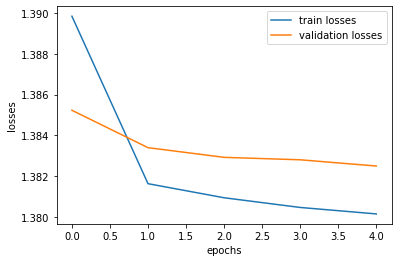

In [39]:
# Plotting in graph for small dataset
plt.plot(epoch_losses, label='train losses')
plt.plot(epoch_val_losses, label='validation losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()

In [11]:
# Run this cell
# with nn.BCEWithLogitsLoss
# With BIG dataset
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
epochs = 1
window_size = 2
#TRAIN_CSV = 'train1.csv'
TRAIN_CSV = 'train_original.csv'

train_df = pd.read_csv(TRAIN_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = train_X
epoch_losses = list()
epoch_val_losses = list()

#keeping vocab size same as embedding dim
model_param = ModelParam(101, 101, 200, 200, 200)
model = crossLingualModel(model_param)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
batch_size = 64

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for epoch in range(epochs):
    number_of_predictions = 0
    dataset = train_X
    intermediate_losses = list()
    for index, row in dataset.iterrows():
        if (index % 100) == 0:
            print('train dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)
     
        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                lang1_array = np.array(w2v_model.wv[word_lang1])
                
                #For normalizing array
#                 norm = np.linalg.norm(lang1_array)
#                 lang1_array = lang1_array/norm
                
                context_words_lang1_array.append(lang1_array)
           
            for word_lang2 in context_words_lang2:
                lang2_array = np.array(w2v_model.wv[word_lang2])
                
                #For normalizing array
#                 norm = np.linalg.norm(lang2_array)
#                 lang2_array = lang2_array/norm
                
                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)
            
            
            
            #embedding for target word in lang1
            target1 = w2v_model.wv[center_word_lang1]
            
            # For normalizing
#             norm1 = np.linalg.norm(target1)
#             target1 = target1/norm1
            
            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)
            
            target1 = get_normalized_tensor(target1)
            
            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)
            
            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)
            
#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))
            
            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
           
            #embedding for target word in lang2
            target2 = w2v_model.wv[center_word_lang2]
            
            # For normalizing
#             norm2 = np.linalg.norm(target2)
#             target2 = target2/norm2
            
            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)
            
            target2 = get_normalized_tensor(target2)
        
            prediction2 = get_normalized_tensor(prediction2)
            
            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

            summed_loss = loss_lang1 + loss_lang2 
            intermediate_losses.append(summed_loss.item())
            
            if(number_of_predictions % batch_size == 0):
                model.zero_grad()
                summed_loss.backward()
                optimizer.step()
                number_of_predictions = 0
                #print('updated model params')
            
            
#     print('intermediate_losses')
#     print(intermediate_losses)
    
    epoch_losses.append(np.mean(intermediate_losses))
    
    # Validation
    with torch.no_grad():
        dataset = test_X
        intermediate_val_losses = list()
        for index, row in dataset.iterrows():
#             if (index % 10) == 0:
#                 print('validation dataset index', index)
            #calculate paragraph vector for entire row
            sent_vector = get_mean_vector(text_to_word_list(row))
            #print(sent_vector)

            #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

            for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
                context_words_lang1_array = []
                context_words_lang2_array = []
                for word_lang1 in context_words_lang1:
                    lang1_array = np.array(w2v_model.wv[word_lang1])

                    #For normalizing array
#                     norm = np.linalg.norm(lang1_array)
#                     lang1_array = lang1_array/norm

                    context_words_lang1_array.append(lang1_array)

                for word_lang2 in context_words_lang2:
                    lang2_array = np.array(w2v_model.wv[word_lang2])

                    #For normalizing array
#                     norm = np.linalg.norm(lang2_array)
#                     lang2_array = lang2_array/norm

                    context_words_lang2_array.append(lang2_array)

                prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



                #embedding for target word in lang1
                target1 = w2v_model.wv[center_word_lang1]

                # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

                target1 = torch.from_numpy(target1)
                target1 = torch.autograd.Variable(target1)
                target1 = target1.reshape(1,-1)
            
                target1 = get_normalized_tensor(target1)

                # Normalize prediction1
    #             normPrediction1 = transforms.Normalize(prediction1, prediction1)
    #             #x = torch.randn(3, 224, 224)
    #             prediction1 = normPrediction1(prediction1)

                
                prediction1 = get_normalized_tensor(prediction1)
                #print(prediction1)

    #             if(epoch == 0):
    #                 print(prediction1)
    #                 print(prediction2)
                    #print(target1)
                    #print(np.sum(target1))

                loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)

                #embedding for target word in lang2
                target2 = w2v_model.wv[center_word_lang2]

                # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

                target2 = torch.from_numpy(target2)
                target2 = torch.autograd.Variable(target2)
                target2 = target2.reshape(1,-1)
            
                target2 = get_normalized_tensor(target2)
                
               
                prediction2 = get_normalized_tensor(prediction2)

                loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

                summed_loss = loss_lang1 + loss_lang2  

                
                intermediate_val_losses.append(summed_loss.item())
                
                ## Assuming below lines not needed for Validation. need to confirm
                #model.zero_grad()
                #summed_loss.backward()
                #optimizer.step()

#         print('intermediate_val_losses')
#         print(intermediate_val_losses)

        epoch_val_losses.append(np.mean(intermediate_val_losses))
    
    
print('epoch_losses ',epoch_losses)
print(' ')
print('epoch_val_losses ',epoch_val_losses)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

epoch_losses  [1.3536577944095838]
 
epoch_val_losses  [1.3523250991463052]
End Time = 16:50:01


In [ ]:
# Plotting in graph for LARGE dataset
plt.plot(epoch_losses, label='train losses')
plt.plot(epoch_val_losses, label='validation losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()

In [19]:
# Run this cell
# Check if word in vocabulary
unique_unknown_words = set()
def get_word_embedding(word):
    if word in w2v_model.wv:
        return w2v_model.wv[word]
    else:
        #print('out of vocabulary word')
        unique_unknown_words.add(word)
        return np.zeros(w2v_dim)
    
# print('zero array ', len(np.array(get_word_embedding('TEST'))))

In [ ]:
# 
# Testing
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
# epochs = 10
window_size = 2
#TEST_CSV = 'test1.csv'
TEST_CSV = 'test_original.csv'

test_df = pd.read_csv(TEST_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
# from sklearn.model_selection import train_test_split
# train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()


#keeping vocab size same as embedding dim
# model_param = ModelParam(101, 101, 200, 200, 200)
# model = crossLingualModel(model_param)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        print('test dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)

        #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                unique_total_words.add(word_lang1)
                #ADD CHECK For out of vocabulary word
                lang1_array = np.array(get_word_embedding(word_lang1))

                #For normalizing array
#                     norm = np.linalg.norm(lang1_array)
#                     lang1_array = lang1_array/norm

                context_words_lang1_array.append(lang1_array)

            for word_lang2 in context_words_lang2:
                unique_total_words.add(word_lang2)
                #ADD CHECK For out of vocabulary word
                lang2_array = np.array(get_word_embedding(word_lang2))

                #For normalizing array
#                     norm = np.linalg.norm(lang2_array)
#                     lang2_array = lang2_array/norm

                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



            #embedding for target word in lang1
            #ADD CHECK For out of vocabulary word
            target1 = get_word_embedding(center_word_lang1)
            
            unique_total_words.add(center_word_lang1)
            

            # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)

            target1 = get_normalized_tensor(target1)

            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)


            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)

#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))

            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)

            #embedding for target word in lang2
            #ADD CHECK For out of vocabulary word
            target2 = get_word_embedding(center_word_lang2)
            
            unique_total_words.add(center_word_lang2)

            # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)

            target2 = get_normalized_tensor(target2)


            prediction2 = get_normalized_tensor(prediction2)

            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

            summed_loss = loss_lang1 + loss_lang2  


            intermediate_test_losses.append(summed_loss.item())

            ## Assuming below lines not needed for test. need to confirm
            #model.zero_grad()
            #summed_loss.backward()
            #optimizer.step()

    print('intermediate_test_losses')
    print(intermediate_test_losses)

    epoch_test_losses.append(np.mean(intermediate_test_losses))
    

print('epoch_test_losses ',epoch_test_losses)
print('unique_total_words = ',len(unique_total_words))
print('unique_unknown_words = ',len(unique_unknown_words))



In [17]:
# PLEASE CHECK THIS CELL CAREFULLY
# Run this cell
# Testing for ROC curve with sent vector change
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
# epochs = 10
window_size = 2
#TEST_CSV = 'test1.csv'
#TEST_CSV = 'test_original.csv'
TEST_CSV = 'test_all_original.csv'

test_df = pd.read_csv(TEST_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
# from sklearn.model_selection import train_test_split
# train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()


#keeping vocab size same as embedding dim
# model_param = ModelParam(101, 101, 200, 200, 200)
# model = crossLingualModel(model_param)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
threshold = 0.8
actual_zero_below_threshold = 0
found_zero_below_threshold = 0
actual_one_below_threshold = 0
actual_one_above_threshold = 0
found_one_above_threshold = 0
actual_zero_above_threshold = 0

y_pred = list()
y_true = list()

if_to_print_output = 0

# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        #print('test dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)
        
        sent_vector_x86 = get_mean_vector(text_to_word_list(row['lang1']))
        sent_vector_x86 = get_normalized_array_from_array_using_tensor_formula(sent_vector_x86)
        sent_vector_arm = get_mean_vector(text_to_word_list(row['lang2']))
        sent_vector_arm = get_normalized_array_from_array_using_tensor_formula(sent_vector_arm)
        #print('sent_vector_x86 ',sent_vector_x86)
        #print('sent_vector_arm ',sent_vector_arm)
#         cos_sim = np.dot(sent_vector_x86, sent_vector_arm)/(np.linalg.norm(sent_vector_x86)*np.linalg.norm(sent_vector_arm))
#         print('cos_sim ', cos_sim)
        
        result = 1 - spatial.distance.cosine(sent_vector_x86, sent_vector_arm)
        # Calculates the distance as defined by the MaLSTM model
#         result = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), \
#                         output_shape=lambda x: (x[0][0], 1))([sent_vector_x86, sent_vector_arm])

#         result = cityblock(sent_vector_x86, sent_vector_arm)
        
        
        #print('if_similar ',row['if_similar'])
        #print('result ',result)
        #print('type = ',type(row['if_similar']))
        if(result < threshold):
            y_pred.append(0)
            found_zero_below_threshold += 1
            if(row['if_similar'] == 0):
                actual_zero_below_threshold += 1
            else:
                actual_one_below_threshold += 1
        else:
            y_pred.append(1)
            found_one_above_threshold += 1
            if(row['if_similar'] == 1):
                actual_one_above_threshold += 1
            else:
                actual_zero_above_threshold += 1
        y_true.append(row['if_similar'])

        #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                unique_total_words.add(word_lang1)
                #ADD CHECK For out of vocabulary word
                lang1_array = np.array(get_word_embedding(word_lang1))

                #For normalizing array
#                     norm = np.linalg.norm(lang1_array)
#                     lang1_array = lang1_array/norm

                context_words_lang1_array.append(lang1_array)

            for word_lang2 in context_words_lang2:
                unique_total_words.add(word_lang2)
                #ADD CHECK For out of vocabulary word
                lang2_array = np.array(get_word_embedding(word_lang2))

                #For normalizing array
#                     norm = np.linalg.norm(lang2_array)
#                     lang2_array = lang2_array/norm

                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



            #embedding for target word in lang1
            #ADD CHECK For out of vocabulary word
            target1 = get_word_embedding(center_word_lang1)
            
            unique_total_words.add(center_word_lang1)
            

            # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)

            target1 = get_normalized_tensor(target1)

            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)


            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)

#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))

            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
            
            if(if_to_print_output<2):
                print('output ',prediction1)
                print('ground truth ',target1)
                print('loss x86', loss_lang1)
            
            #embedding for target word in lang2
            #ADD CHECK For out of vocabulary word
            target2 = get_word_embedding(center_word_lang2)
            
            unique_total_words.add(center_word_lang2)

            # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)

            target2 = get_normalized_tensor(target2)


            prediction2 = get_normalized_tensor(prediction2)

            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
            
            if(if_to_print_output<2):
                print('output ',prediction2)
                print('ground truth ',target2)
                print('loss arm', loss_lang1)
                if_to_print_output += 1

            summed_loss = loss_lang1 + loss_lang2  


            intermediate_test_losses.append(summed_loss.item())

            ## Assuming below lines not needed for test. need to confirm
            #model.zero_grad()
            #summed_loss.backward()
            #optimizer.step()

    #print('intermediate_test_losses')
    #print(intermediate_test_losses)

    epoch_test_losses.append(np.mean(intermediate_test_losses))
    

print('epoch_test_losses ',epoch_test_losses)
#print('unique_total_words = ',len(unique_total_words))
#print('unique_unknown_words = ',len(unique_unknown_words))

# print('with manhattan_distance')
print('with normalization, threshold ',threshold)
print('actual_zero_below_threshold ',actual_zero_below_threshold)
print('found_zero_below_threshold ',found_zero_below_threshold)
print('actual_one_below_threshold ',actual_one_below_threshold)
print('actual_one_above_threshold ',actual_one_above_threshold)
print('found_one_above_threshold ',found_one_above_threshold)
print('actual_zero_above_threshold ',actual_zero_above_threshold)



/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


output  tensor([[6.8440e-01, 4.4021e-02, 1.9737e-01, 8.2299e-02, 7.6318e-01, 9.8808e-02,
         3.0216e-03, 4.1444e-02, 5.3627e-02, 1.9861e-01, 3.5944e-01, 2.6297e-01,
         1.1134e-01, 9.6503e-02, 1.6601e-01, 1.6606e-01, 1.5104e-01, 2.6335e-01,
         2.5068e-01, 7.9103e-02, 9.5673e-01, 7.2874e-01, 2.4573e-01, 3.0512e-01,
         8.3010e-01, 6.0079e-03, 1.4325e-02, 3.0978e-02, 6.8462e-01, 4.1286e-01,
         2.1328e-02, 2.0172e-01, 2.1426e-02, 9.9420e-01, 1.9171e-01, 2.2902e-02,
         1.5727e-01, 6.9884e-01, 3.1535e-01, 1.9871e-01, 2.7940e-02, 1.7599e-02,
         4.3735e-02, 2.9893e-01, 3.8005e-01, 3.0119e-01, 4.0379e-02, 3.4043e-01,
         5.1567e-01, 3.5169e-01, 7.9269e-02, 4.9033e-01, 5.4237e-01, 3.9473e-01,
         2.1534e-02, 6.8075e-03, 6.5596e-01, 6.9981e-02, 9.0846e-02, 3.4336e-01,
         4.9533e-02, 8.2195e-01, 1.8630e-01, 1.1219e-01, 6.0581e-02, 2.3383e-02,
         5.3251e-01, 3.5870e-02, 7.1543e-01, 8.1446e-01, 6.4794e-01, 2.2682e-01,
         1.8775e-02,

/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


epoch_test_losses  [1.3553053496443233]
with normalization, threshold  0.8
actual_zero_below_threshold  699
found_zero_below_threshold  1563
actual_one_below_threshold  864
actual_one_above_threshold  9441
found_one_above_threshold  17382
actual_zero_above_threshold  7941


In [79]:
# PLEASE CHECK THIS CELL CAREFULLY
# Run this cell
# Testing for ROC curve with sent vector change WITH UPDATED SENT CALCULATION

window_size = 2
#TEST_CSV = 'test1.csv'
#TEST_CSV = 'test_original.csv'
# TEST_CSV = 'test_all_original.csv'
# TEST_CSV = 'test_all_original_short.csv'
TEST_CSV = 'test_all_original_short_1.csv'


test_df = pd.read_csv(TEST_CSV)


questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()


# threshold = -.003
threshold = -0.009

actual_zero_below_threshold = 0
found_zero_below_threshold = 0
actual_one_below_threshold = 0
actual_one_above_threshold = 0
found_one_above_threshold = 0
actual_zero_above_threshold = 0

y_pred = list()
y_true = list()

if_to_print_output = 0

# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        #print('test dataset index', index)
        #calculate paragraph vector for entire row
        
        sent_vector_x86 = row['lang1'] #get_mean_vector(text_to_word_list())
        sent_vector_arm = row['lang2'] #get_mean_vector(text_to_word_list())
        
        prediction1, prediction2 = model(sent_vector_x86, sent_vector_arm, '')
#         prediction1 = get_normalized_tensor(prediction1).detach().numpy()
#         prediction2 = get_normalized_tensor(prediction2).detach().numpy()
        
        prediction1 = prediction1.detach().numpy()
        prediction2 = prediction2.detach().numpy()
        
#         print('prediction1 for test ',prediction1)
#         print('prediction2 for test ',prediction2)
        
        #print('sent_vector_x86 ',sent_vector_x86)
        #print('sent_vector_arm ',sent_vector_arm)
#         cos_sim = np.dot(sent_vector_x86, sent_vector_arm)/(np.linalg.norm(sent_vector_x86)*np.linalg.norm(sent_vector_arm))
#         print('cos_sim ', cos_sim)
        
        result = 1 - spatial.distance.cosine(prediction1, prediction2)
        # Calculates the distance as defined by the MaLSTM model
#         result = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), \
#                         output_shape=lambda x: (x[0][0], 1))([sent_vector_x86, sent_vector_arm])

#         result = cityblock(sent_vector_x86, sent_vector_arm)
        
        
        #print('if_similar ',row['if_similar'])
        #print('result ',result)
        #print('type = ',type(row['if_similar']))
        if(result < threshold):
            y_pred.append(0)
            found_zero_below_threshold += 1
            if(row['if_similar'] == 0):
                actual_zero_below_threshold += 1
            else:
                actual_one_below_threshold += 1
        else:
            y_pred.append(1)
            found_one_above_threshold += 1
            if(row['if_similar'] == 1):
                actual_one_above_threshold += 1
            else:
                actual_zero_above_threshold += 1
        y_true.append(row['if_similar'])

        #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

#         for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
#             context_words_lang1_array = []
#             context_words_lang2_array = []
#             for word_lang1 in context_words_lang1:
#                 unique_total_words.add(word_lang1)
#                 #ADD CHECK For out of vocabulary word
#                 lang1_array = np.array(get_word_embedding(word_lang1))

#                 #For normalizing array
# #                     norm = np.linalg.norm(lang1_array)
# #                     lang1_array = lang1_array/norm

#                 context_words_lang1_array.append(lang1_array)

#             for word_lang2 in context_words_lang2:
#                 unique_total_words.add(word_lang2)
#                 #ADD CHECK For out of vocabulary word
#                 lang2_array = np.array(get_word_embedding(word_lang2))

#                 #For normalizing array
# #                     norm = np.linalg.norm(lang2_array)
# #                     lang2_array = lang2_array/norm

#                 context_words_lang2_array.append(lang2_array)

#             prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



#             #embedding for target word in lang1
#             #ADD CHECK For out of vocabulary word
#             target1 = get_word_embedding(center_word_lang1)
            
#             unique_total_words.add(center_word_lang1)
            

#             # For normalizing
# #                 norm1 = np.linalg.norm(target1)
# #                 target1 = target1/norm1

#             target1 = torch.from_numpy(target1)
#             target1 = torch.autograd.Variable(target1)
#             target1 = target1.reshape(1,-1)

#             target1 = get_normalized_tensor(target1)

#             # Normalize prediction1
# #             normPrediction1 = transforms.Normalize(prediction1, prediction1)
# #             #x = torch.randn(3, 224, 224)
# #             prediction1 = normPrediction1(prediction1)


#             prediction1 = get_normalized_tensor(prediction1)
#             #print(prediction1)

# #             if(epoch == 0):
# #                 print(prediction1)
# #                 print(prediction2)
#                 #print(target1)
#                 #print(np.sum(target1))

#             loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
            
#             if(if_to_print_output<2):
#                 print('output ',prediction1)
#                 print('ground truth ',target1)
#                 print('loss x86', loss_lang1)
            
#             #embedding for target word in lang2
#             #ADD CHECK For out of vocabulary word
#             target2 = get_word_embedding(center_word_lang2)
            
#             unique_total_words.add(center_word_lang2)

#             # For normalizing
# #                 norm2 = np.linalg.norm(target2)
# #                 target2 = target2/norm2

#             target2 = torch.from_numpy(target2)
#             target2 = torch.autograd.Variable(target2)
#             target2 = target2.reshape(1,-1)

#             target2 = get_normalized_tensor(target2)


#             prediction2 = get_normalized_tensor(prediction2)

#             loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
            
#             if(if_to_print_output<2):
#                 print('output ',prediction2)
#                 print('ground truth ',target2)
#                 print('loss arm', loss_lang1)
#                 if_to_print_output += 1

#             summed_loss = loss_lang1 + loss_lang2  


#             intermediate_test_losses.append(summed_loss.item())

#             ## Assuming below lines not needed for test. need to confirm
#             #model.zero_grad()
#             #summed_loss.backward()
#             #optimizer.step()

#     #print('intermediate_test_losses')
#     #print(intermediate_test_losses)

#     epoch_test_losses.append(np.mean(intermediate_test_losses))
    

# print('epoch_test_losses ',epoch_test_losses)
#print('unique_total_words = ',len(unique_total_words))
#print('unique_unknown_words = ',len(unique_unknown_words))

# print('with manhattan_distance')
print('with normalization, threshold ',threshold)
print('actual_zero_below_threshold ',actual_zero_below_threshold)
print('found_zero_below_threshold ',found_zero_below_threshold)
print('actual_one_below_threshold ',actual_one_below_threshold)
print('actual_one_above_threshold ',actual_one_above_threshold)
print('found_one_above_threshold ',found_one_above_threshold)
print('actual_zero_above_threshold ',actual_zero_above_threshold)



/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:85: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


with normalization, threshold  -0.009
actual_zero_below_threshold  30
found_zero_below_threshold  46
actual_one_below_threshold  16
actual_one_above_threshold  33
found_one_above_threshold  53
actual_zero_above_threshold  20


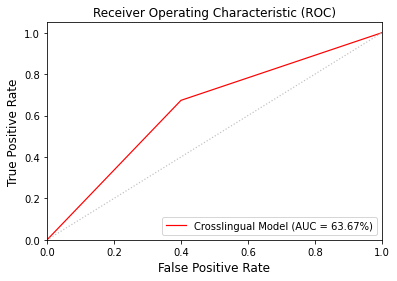

In [80]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)*100

plt.figure()
plt.plot(fpr, tpr, color='red', linewidth = 1.2, label='Crosslingual Model (AUC = %0.2f%%)' % roc_auc)

plt.plot([0, 1], [0, 1], color = 'silver', linestyle = ':', linewidth = 1.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()